<a href="https://colab.research.google.com/github/helmahdy/Advanced-Machine-Learning/blob/main/helmahdy_4_RNN_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use any or all of the methods we discussed in class to improve weather time-series forecasting
problem discussed in class. These methods can include:
1. Adjusting the number of units in each recurrent layer in the stacked setup
2. Using layer_lstm() instead of layer_gru().
3. Using a combination of 1d_convnets and RNN.
Don’t forget to eventually run the best-performing models (in terms of validation MAE) on the
test set!


In [ ]:
import keras
from keras.layers import LSTM
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from google.colab import drive
from keras.layers import LSTM
from keras.layers import Embedding

In [ ]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Data Preparation

In [ ]:
data_dir = '/content/gdrive/MyDrive/Colab Notebooks'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
#convert all of these lines of data into a Numpy array
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


We will create data generator that yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures.



In [ ]:
   def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        

We will use the following parameters values:

 * lookback = 720, i.e. our observations will go back 5 days.

 * steps = 6, i.e. our observations will be sampled at one data point per hour.
 * delay = 144, i.e. our targets will be 24 hours in the future.




In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

Next we will preprocess the data by normalizing each timeseries independently so that they all take small values on a similar scale

In [ ]:
#using the first 200,000 timesteps as training data, we compute the mean and standard deviation only on this fraction of the data:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# Using layer_lstm() instead of layer_gru()

Using layer_gru() gave training loss: 0.2074 and validation loss: 0.3034. Now let's use layer_lstm() instead

In [ ]:
model = Sequential()
model.add(LSTM(32))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 101s 198ms/step - loss: 0.3363 - val_loss: 0.2693
Epoch 2/20
500/500 [==============================] - 100s 200ms/step - loss: 0.2774 - val_loss: 0.2702
Epoch 3/20
500/500 [==============================] - 99s 199ms/step - loss: 0.2660 - val_loss: 0.2757
Epoch 4/20
500/500 [==============================] - 99s 199ms/step - loss: 0.2576 - val_loss: 0.2762
Epoch 5/20
500/500 [==============================] - 97s 194ms/step - loss: 0.2474 - val_loss: 0.2858
Epoch 6/20
500/500 [==============================] - 98s 197ms/step - loss: 0.2416 - val_loss: 0.2851
Epoch 7/20
500/500 [==============================] - 98s 196ms/step - loss: 0.2325 - val_loss: 0.2858
Epoch 8/20
500/500 [==============================] - 97s 194ms/step - loss: 0.2303 - val_loss: 0.2882
Epoch 9/20
500/500 [==============================] - 100s 200ms/step - loss: 0.2254 - val_loss: 0.2888
Epoch 10/20
500/500 [==============================] - 98s 196ms/step 

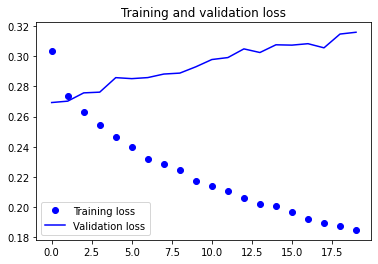

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Using recurrent dropout to fight overfitting with Layer_LSTM()


In [ ]:
#a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask)
from keras import layers
model = Sequential()
model.add(LSTM(32, 
               dropout=0.5,
               recurrent_dropout=0.2,
               input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 173s 341ms/step - loss: 0.3828 - val_loss: 0.2919
Epoch 2/40
500/500 [==============================] - 171s 343ms/step - loss: 0.3109 - val_loss: 0.2795
Epoch 3/40
500/500 [==============================] - 170s 340ms/step - loss: 0.3002 - val_loss: 0.2782
Epoch 4/40
500/500 [==============================] - 171s 342ms/step - loss: 0.2956 - val_loss: 0.2920
Epoch 5/40
500/500 [==============================] - 171s 342ms/step - loss: 0.2902 - val_loss: 0.2824
Epoch 6/40
500/500 [==============================] - 172s 344ms/step - loss: 0.2840 - val_loss: 0.2777
Epoch 7/40
500/500 [==============================] - 172s 344ms/step - loss: 0.2784 - val_loss: 0.2828
Epoch 8/40
500/500 [==============================] - 169s 339ms/step - loss: 0.2710 - val_loss: 0.2812
Epoch 9/40
500/500 [==============================] - 169s 338ms/step - loss: 0.2688 - val_loss: 0.2827
Epoch 10/40
500/500 [==============================] - 168s 337m

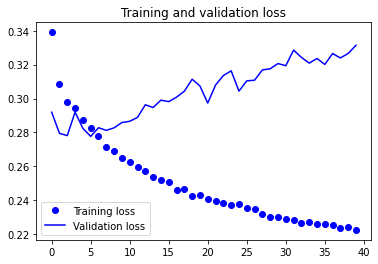

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# Using recurrent dropout to fight overfitting with layers_gru()

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 152s 300ms/step - loss: 0.3550 - val_loss: 0.2804
Epoch 2/40
500/500 [==============================] - 150s 300ms/step - loss: 0.3114 - val_loss: 0.2749
Epoch 3/40
500/500 [==============================] - 152s 304ms/step - loss: 0.3009 - val_loss: 0.2763
Epoch 4/40
500/500 [==============================] - 150s 299ms/step - loss: 0.2996 - val_loss: 0.2684
Epoch 5/40
500/500 [==============================] - 149s 299ms/step - loss: 0.2929 - val_loss: 0.2753
Epoch 6/40
500/500 [==============================] - 149s 299ms/step - loss: 0.2882 - val_loss: 0.2680
Epoch 7/40
500/500 [==============================] - 150s 300ms/step - loss: 0.2866 - val_loss: 0.2679
Epoch 8/40
500/500 [==============================] - 150s 299ms/step - loss: 0.2821 - val_loss: 0.2711
Epoch 9/40
500/500 [==============================] - 151s 302ms/step - loss: 0.2786 - val_loss: 0.2825
Epoch 10/40
500/500 [==============================] - 151s 303m

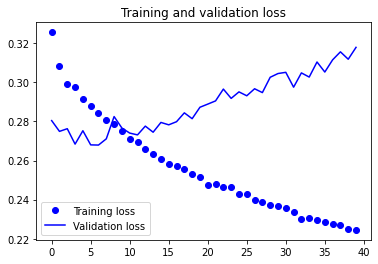

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


# Stacking recurrent layers and changing the number of units 

To further imporve the model performance, we can increase the capacity of the network. To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True:

In [ ]:
from keras import layers
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.3,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, activation='relu',
                     dropout=0.3, 
                     recurrent_dropout=0.5,))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=300,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


300/300 [==============================] - 454s 1s/step - loss: 0.3687 - val_loss: 0.3007
Epoch 2/20
300/300 [==============================] - 451s 2s/step - loss: 0.3237 - val_loss: 0.2814
Epoch 3/20
300/300 [==============================] - 451s 2s/step - loss: 0.3136 - val_loss: 0.2887
Epoch 4/20
300/300 [==============================] - 453s 2s/step - loss: 0.3059 - val_loss: 0.2755
Epoch 5/20
300/300 [==============================] - 450s 1s/step - loss: 0.2985 - val_loss: 0.2768
Epoch 6/20
300/300 [==============================] - 443s 1s/step - loss: 0.2920 - val_loss: 0.2771
Epoch 7/20
300/300 [==============================] - 458s 2s/step - loss: 0.2866 - val_loss: 0.2844
Epoch 8/20
300/300 [==============================] - 463s 2s/step - loss: 0.2815 - val_loss: 0.2823
Epoch 9/20
300/300 [==============================] - 469s 2s/step - loss: 0.2791 - val_loss: 0.2756
Epoch 10/20
300/300 [==============================] - 467s 2s/step - loss: 0.2764 - val_loss: 0.2824


https://github.com/tensorflow/tensorflow/issues/40944



https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1


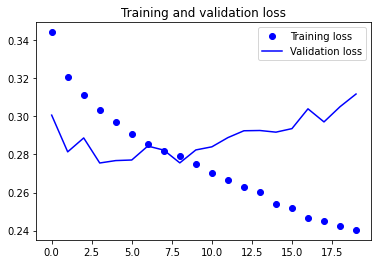

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
from keras import layers
model = Sequential()
model.add(layers.GRU(80,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, activation='relu',
                     dropout=0.2, 
                     recurrent_dropout=0.5,))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_steps)



Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 214s 2s/step - loss: 0.3746 - val_loss: 0.3090
Epoch 2/30
100/100 [==============================] - 208s 2s/step - loss: 0.3252 - val_loss: 0.2794
Epoch 3/30
100/100 [==============================] - 209s 2s/step - loss: 0.3167 - val_loss: 0.2849
Epoch 4/30
100/100 [==============================] - 210s 2s/step - loss: 0.3186 - val_loss: 0.2816
Epoch 5/30
100/100 [==============================] - 210s 2s/step - loss: 0.3056 - val_loss: 0.2837
Epoch 6/30
100/100 [==============================] - 211s 2s/step - loss: 0.3068 - val_loss: 0.2706
Epoch 7/30
100/100 [==============================] - 209s 2s/step - loss: 0.3049 - val_loss: 0.2747
Epoch 8/30
100/100 [==============================] - 207s 2s/step - loss: 0.3007 - val_loss: 0.2768
Epoch 9/30
100/100 [==============================] - 207s 2s/step - loss: 0.2986 - val_loss: 0.2764
Epoch 10/30
100/100 [==============================] - 205s 2s/step - loss: 0.2953 - val_loss: 0.2803


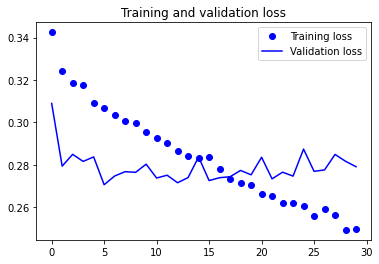

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Results:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## Here is a brief summary of the results: 

In [ ]:
pd.read_excel('/content/drive/My Drive/results.xlsx', 'Sheet2')

,Model,Training Loss,Validation loss
0,First Recurrent Baseline - layer_lstm(),0.1843,0.3158
1,Recurrent dropout with Layer_LSTM(),0.2223,0.3314
2,Recurrent dropout with layers_gru(),0.2248,0.3179
3,Stacking recurrent layers/ changing units number,0.2413,0.3118
4,Stacking recurrent layers/ increasing units nu...,0.2493,0.2791


It should be noted that all these models are computationaly expensive. Each took ~4 hrs to run in google colab. 

*  The first model using Layers_lstm() (baseline) was clearly overfitting as seen in the difference between the training and validation loss.
*   Using dropout method wasn't giving better results either.
*   Stacking the recurrent layers , using drop out and increasing the number of units slightly improved the performance in validation.
*   The best performer model here was the one with the highest number of units, proving that increasing the network capacity plays a big part in the performance.



